In [66]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [67]:
def draw(df, name):
    '''
    plot the figure of df with title 'name'

    :param df: input data
    :param name: name of title
    :return:
    '''
    f1 = plt.figure(figsize=(15,10))
    ax1 = f1.add_subplot(111)
    for i in df:
        ax1.plot(df[i], label=i)
    plt.legend()
    plt.title(name)
    plt.show()

In [68]:
# global variables
win_size = 5    # time window
alpha = 0.5     # parameter in computing EMA

with open('./sp500-historical-components.json','r') as f:
    total_sp500 = json.loads(f.read())   # total_sp500 is a list

In [69]:
# clean the data
comp_df = pd.DataFrame(data = total_sp500)
comp_df = comp_df.sort_values(by = 'Date', ascending = True)  # sort the dataframe by date
comp_df = comp_df.reset_index(drop = True)
comp_df['Date'] = pd.to_datetime(comp_df['Date'], format = '%Y/%m/%d')
total_mon = len(comp_df['Date'])

In [70]:
# find the union of the stocks over the entire period
symbols = comp_df['Symbols']
union = symbols[0]
for i in range(1,len(symbols)):
    union = list(set(union).union(set(symbols[i])))

In [71]:
# construct a big dataframe that stores all the price relatives of all stocks over the entire period
close = {}
for stock in union:
    filename = './data1/' + stock + '.csv'
    file = pd.read_csv(filename)
    file.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)          
    # extract the adj close prices
    adj_close = file['Close']
    adj_close.index = file['Date']
    close[stock] = adj_close
close_df = pd.DataFrame(close)

close_df = close_df.dropna(axis = 0, how = 'all')
pr_df = close_df / close_df.shift(1)

In [72]:
# identify anomalies
pr_df[pr_df>1.5] = np.nan
pr_df[pr_df<0.5] = np.nan
close_df[pr_df>1.5] = np.nan
close_df[pr_df<0.5] = np.nan

In [73]:
[T,nstk] = pr_df.shape
# compute trend representations for the entire period
EMA = np.ones(shape = (T,nstk))
for i in range(1,T):
    EMA[i] = (1 - alpha) * EMA[i-1] / pr_df.iloc[i,] + alpha
EMA = pd.DataFrame(data = EMA, columns = pr_df.columns, index = pr_df.index)
SMA = close_df.rolling(win_size).mean()/close_df
PP = close_df.rolling(win_size).max() / close_df
LL = close_df.rolling(win_size).min() / close_df  
VOL = (close_df.rolling(win_size).max()-close_df.rolling(win_size).min()) / close_df 
STD = close_df.rolling(win_size).std() / close_df

In [74]:
factors = [EMA, SMA, LL, PP]
factors_name = ['ema','sma','ll','pp']
for i,v in enumerate(factors):
    factors[i].reset_index(inplace=True)

In [75]:
def simplex_projection_selfnorm2(v,b):
    '''
    innovative algorithmn used to solve KKT conditions

    :param b: parameter of equality contraints
    :return:
    '''
    while (max(abs(v)) > 1e6):
        v = v / 10
        break
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)
    c = np.array(range(1, len(u)+1, 1))
    sample = u - (sv - b) / c
    sample = sample[sample>0]
    rho = np.argmin(sample)
    theta = (sv[rho] - b) / (rho+1)
    w = np.maximum(v - theta, 0)
    return w

In [76]:
def trading_representative(pr, window_size, end_date):
    '''

    :param pr: price relative
    :param window_size: days rolling back for further calculation
    :param end_date: current date
    :return: portfolio weights
    '''
    pick = comp_df.loc[comp_df['Date'] <= end_date][-2:]
    ## find the intersection of the S&P500 stocks during the last two months
    pick = list(pick['Symbols'].values)
    stocks = list(set(pick[0]).intersection(set(pick[1])))
    
    # find the corresponding index for end_date and start_date
    end_idx = factors[0][factors[0]['Date'].values <= end_date].index[-1]   #t
    start_idx = end_idx - window_size - 1   #t-6
    
    #acquire the price relative of the overlapping stocks
    sliced_pr = pr.iloc[start_idx:end_idx+1, :].loc[:,stocks]
    sliced_pr[sliced_pr>1.5] = np.nan
    sliced_pr[sliced_pr<0.2] = np.nan
    sliced_pr.dropna(axis=1, how='any',inplace = True)
    stks = list(set(stocks).intersection(set(sliced_pr.columns)))

    # slice computed EMA, SMA, PP
    sliced_factors = []
    for factor in factors:
        tmp = factor.loc[start_idx:end_idx, stks]
        tmp.dropna(axis=1, how='any',inplace = True)
        stks = list(set(stks).intersection(set(tmp.columns)))
        sliced_factors.append(tmp)
    
    #project each trend representation onto Δd space to calculate corresponding eligible portfolio
    for i, sfactor in enumerate(sliced_factors):
        sliced_factors[i] = sfactor.loc[:, stks].apply(lambda x: simplex_projection_selfnorm2(x,1),axis=1)
    sliced_pr = sliced_pr[stks]
    
    rhat_list = []
    rt = (sliced_pr.iloc[-window_size:,]).reset_index(drop=True)
    for sfactor in sliced_factors:
        rhat_list.append((sfactor.iloc[-1-window_size:-1,]).reset_index(drop=True) * rt)
    
    #min_max method to identify the adaptive input of Radial basisi function
    min_list = []
    for rhat in rhat_list:
        min_list.append( np.min(np.sum(rhat,axis=1)) )
    idx = np.argmax(np.array(min_list))
    base = sliced_factors[idx].iloc[-1,:]
    
    #use radial basis function to calculate weighted portfolio
    wlist = []
    final_weights = None 
    for sfactor in sliced_factors:
        if final_weights  is not None:
            final_weights = final_weights + sfactor.iloc[-1, :] * np.exp((-(sfactor.iloc[-1,:]-base)**2).sum()/(2*0.0025)) 
        else:
            final_weights = sfactor.iloc[-1, :] * np.exp((-(sfactor.iloc[-1,:]-base)**2).sum()/(2*0.0025)) 
        wlist.append(sfactor.iloc[-1, :])
        
    #normalize weighted portfolio to eligible portfolio
    w = simplex_projection_selfnorm2(final_weights,1)

    return  w,wlist

In [79]:
start_date = "2008-03-01"
end_date = "2019-01-01"
date_list = close_df.loc[start_date:, :].index.tolist()
ww = {}
result = []
result_single = {}
for ff in factors_name:
    result_single[ff] = []
bmk = []

for date_num,date in enumerate(date_list):
    if date >= end_date:
        break
    for next_date in date_list:
        if next_date > date:
            break
    # call the trading_representative function
    w, wlist = trading_representative(pr_df, win_size, end_date = date)
    ret1 = pr_df.loc[next_date, w.index.tolist()]
    tmp_result = (w*ret1).sum()

    for i, wi in enumerate(wlist):
        result_single[factors_name[i]].append((wi * ret1).sum()) 

    bmk_result = (1*ret1).mean()

    ww[date] = w
    result.append(tmp_result)
    bmk.append(bmk_result)
    if date_num % 50 == 0:
        print(date)

2008-03-03
2008-05-13
2008-07-24
2008-10-03
2008-12-15
2009-02-27
2009-05-11
2009-07-22
2009-10-01
2009-12-11
2010-02-25
2010-05-07
2010-07-20
2010-09-29
2010-12-09
2011-02-22
2011-05-04
2011-07-15
2011-09-26
2011-12-06
2012-02-17
2012-05-01
2012-07-12
2012-09-21
2012-12-05
2013-02-19
2013-05-01
2013-07-12
2013-09-23
2013-12-03
2014-02-14
2014-04-29
2014-07-10
2014-09-19
2014-12-01
2015-02-12
2015-04-27
2015-07-08
2015-09-17
2015-11-27
2016-02-10
2016-04-22
2016-07-05
2016-09-14
2016-11-23
2017-02-07
2017-04-20
2017-06-30
2017-09-12
2017-11-21
2018-02-05
2018-04-18
2018-06-28
2018-09-10
2018-11-19


In [81]:
if type(result) == list:
    result = pd.DataFrame(result)
    result.columns = ['s']
    for i,v in result_single.items():
        result[i] = v

    result['bmk'] = bmk
    saved_result = result.copy()
else:
    result = saved_result.copy()

# regulate the anomalies
result[result>1.05] = 1.05
result[result<0.95] = 0.95

#result.iloc[:, :-1] = result.iloc[:, :-1] - 0.0003

# result.cumprod().plot()

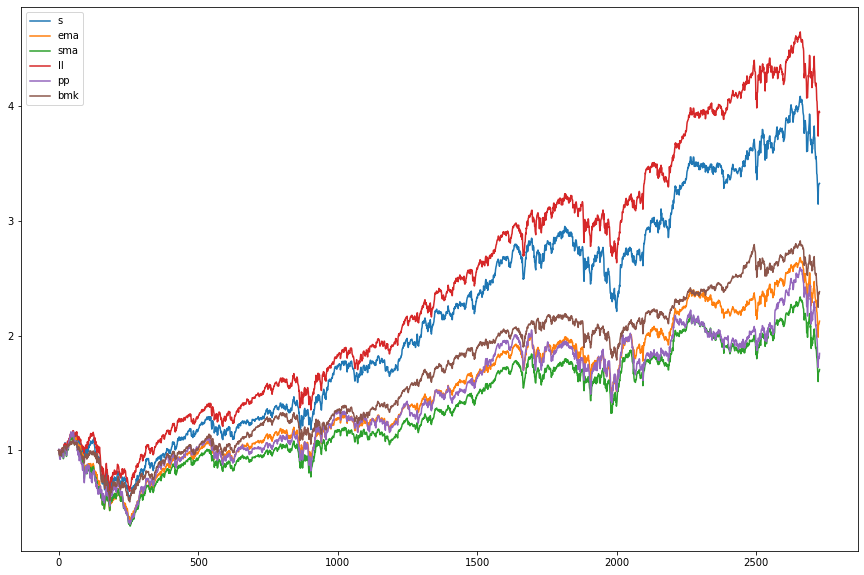

In [82]:
draw(result.cumprod(), '')

In [83]:
date_list[463]

'2009-12-31'

In [84]:
result1 = result.iloc[:464,:]
result2 = result.iloc[464:, :]

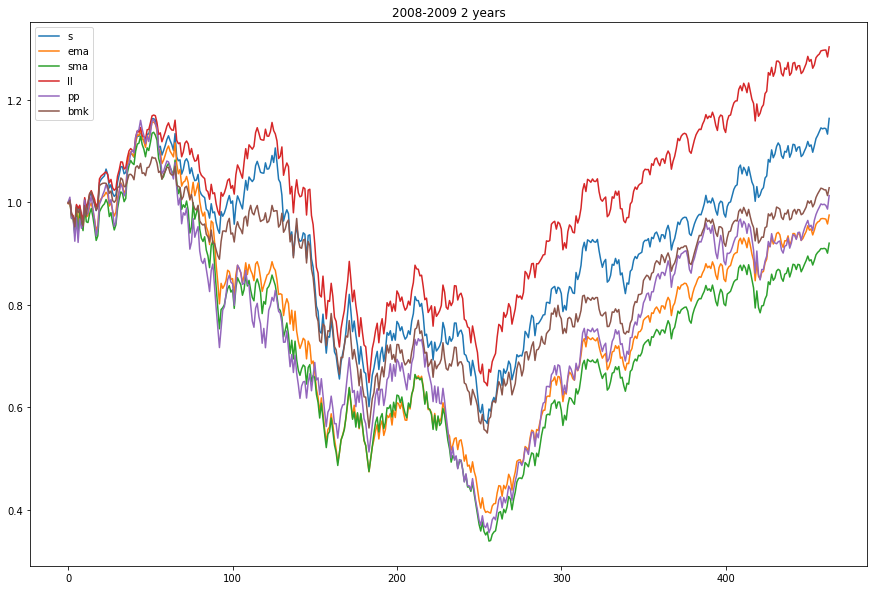

In [85]:
draw(result1.cumprod(), '2008-2009 2 years')

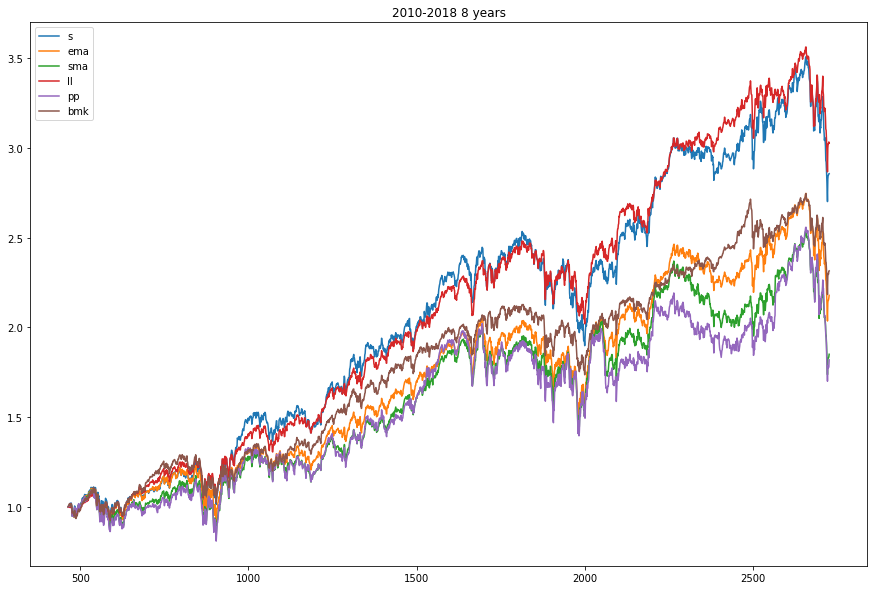

In [86]:
draw(result2.cumprod(), '2010-2018 8 years')

In [87]:
#calcuate sharp ratio of period 1
(result1-1).mean() / (result1-1).std() * np.sqrt(252)

s      0.409235
ema    0.175818
sma    0.119080
ll     0.595662
pp     0.258088
bmk    0.219138
dtype: float64

In [88]:
#calcuate sharp ratio of period 2
(result2-1).mean() / (result2-1).std()* np.sqrt(252)

s      0.747274
ema    0.547745
sma    0.431357
ll     0.856421
pp     0.398353
bmk    0.668970
dtype: float64

In [89]:
#calcuate average annual return of period 1
(result1-1).mean() * 252

s      0.147260
ema    0.073331
sma    0.052644
ll     0.200978
pp     0.125638
bmk    0.076951
dtype: float64

In [90]:
#calcuate average annual return of period 2
(result2-1).mean() * 252

s      0.132674
ema    0.105168
sma    0.090609
ll     0.135956
pp     0.095184
bmk    0.106066
dtype: float64

In [91]:
#calcuate sharp ratio of whole period
(result-1).mean() / (result-1).std() * np.sqrt(252)

s      0.615976
ema    0.406805
sma    0.318521
ll     0.732846
pp     0.339068
bmk    0.494577
dtype: float64

In [92]:
#estimate turnover
pre_i = -1
turnover = []
for i,v in ww.items():
    if pre_i == -1:
        this = v
        pre_i = i
    else:
        tmp = abs(v-this)
        turnover.append(tmp.sum() / this.sum())
        pre_i, this = i, v
np.mean(turnover)  

1.055030805178729

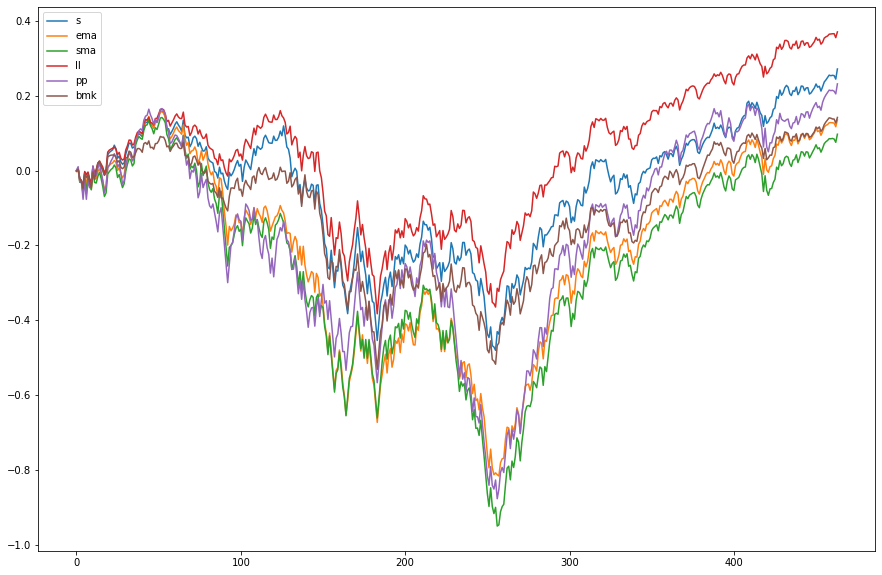

In [93]:
draw((result1-1).cumsum(), '')

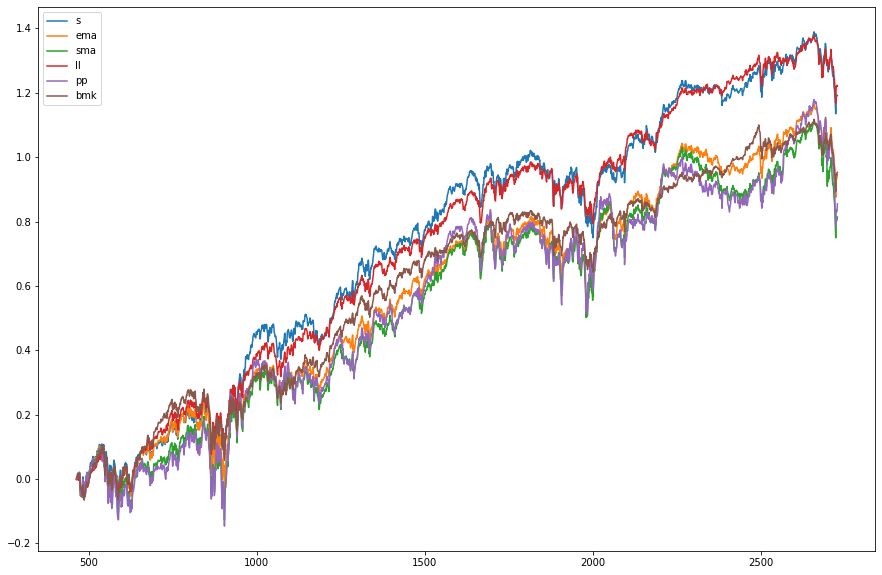

In [94]:
draw((result2-1).cumsum(), '')

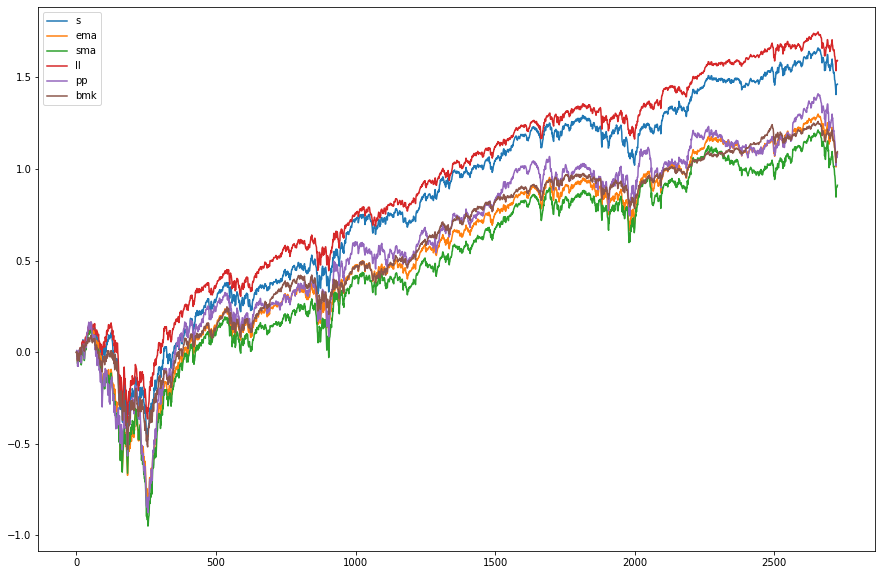

In [95]:
draw((result-1).cumsum(), '')